# Necessary Pythons's imports

You should not import anything else in order to complete exercises in this notebook.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import patches

# Practical problem set

## Zero padding

Zero padding is a simple and often used concept, it refers to adding zeros at the end of a time-domain signal to increase its length. There are a few reasons why you might want to zero pad time-domain data. The most common reason is to make a signal have a power-of-two number of samples. When the time-domain length of a signal is a power of two, radix-2 FFT algorithms, which are extremely efficient, can be used to speed up processing time.

Other uses of zero padding include:
- Adding zeros is equal to interpolating samples of your spectrum with sinc function. Therefore you will find it looking more smoothly. 
- If some peaks were split between two bins, these can be interpolated to some extend and you might be able to retrieve some amplitude information thanks to that.
- If you are trying to plot frequency response of some FIR filter from it's impulse response then you need to add zeros to it. Otherwise you will get as many samples as the length of filter is and this may not be enough.
- If you are trying to convolve your signal with some pattern using FFT, then you need to pad your signals with zeros to the appropriate length. Otherwise result of convolution will be incorrect (replicas in frequency domain will overlap).

### Exercise

Implement a function that will add zeros to the end of the given signal in such a way, that the output is the length of the nearest, greater multiple of two.

In [35]:
def zero_padd(signal):
    ########## Your code goes here ##########
    
    # wyznaczamy najmniejszą potegę dwójki większą lub równą długości sygnału 
    power_of_two = 2
    N = signal.shape[0]
    while (power_of_two <= N):
        power_of_two *= 2
     
    # wyznaczamy ile zer potrzebujemy dodać do sygnału
    needed_zeros = power_of_two - N
    # i dodajemy je
    X = np.concatenate( (signal, np.zeros(needed_zeros)), axis=0 )
    return X

Verify your implementation

Your implementation succeeded


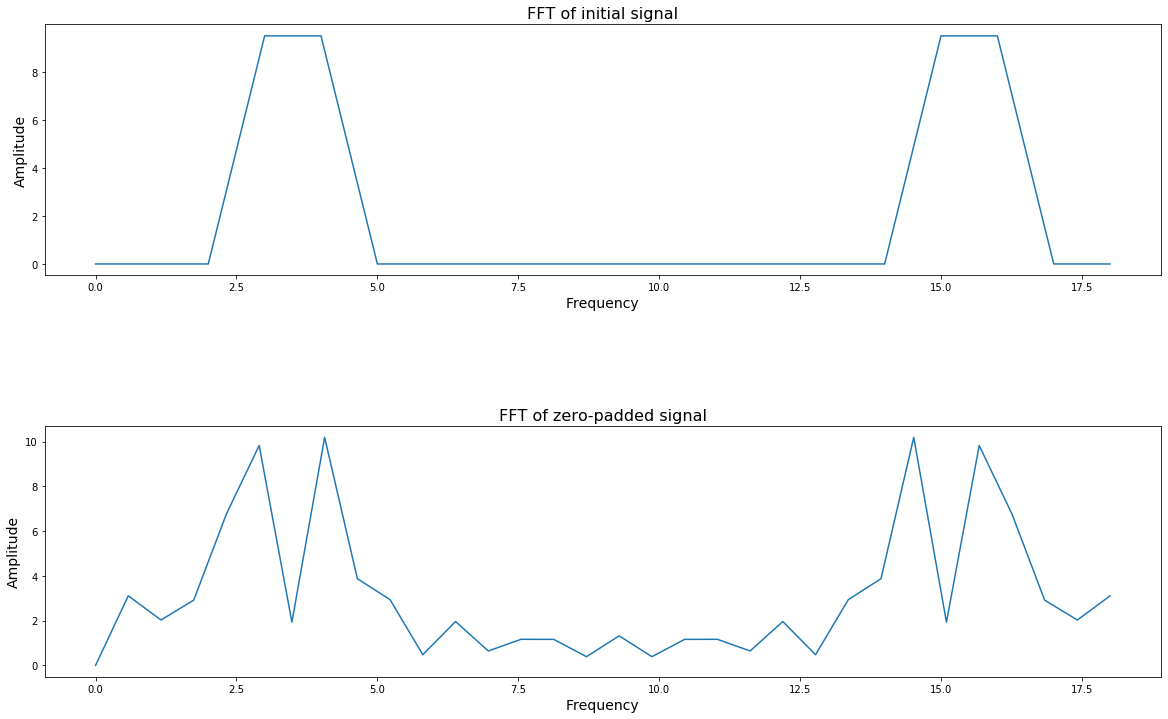

In [36]:
fs = np.random.randint(17,22) # Sampling frequency
dt = 1/fs # Sampling interval
t_s = 0   # Start of sampling 
t_s = 1   # End of sampling 

# Generate timestamps of samples
t = np.arange(0, 1, dt)

# Generate signal consisting of two sines
signal = np.sin(2*np.pi*t*3) + np.sin(2*np.pi*t*4)

# Zero padding using your implementation
X = zero_padd(signal)

# Check length of the singal
print('Your implementation succeeded' if int(X.shape[0]/2) == X.shape[0]/2 else 'Length of signal (' + str(X.shape[0]) + ') is not a multiple of 2!')

# Ploting FFT of initial signal and result
plt.figure(figsize = (20, 12))
plt.subplot(2,1,1)
plt.plot(np.linspace(0,fs-1,fs), np.abs(np.fft.fft(signal)))
plt.xlabel('Frequency', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)
plt.title('FFT of initial signal', fontsize = 16)

plt.subplot(2,1,2)
plt.plot(np.linspace(0,fs-1,X.shape[0]), np.abs(np.fft.fft(X)))
plt.xlabel('Frequency', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)
plt.title('FFT of zero-padded signal', fontsize = 16)
plt.subplots_adjust(hspace = 0.6)
plt.show()

### Question

The signal consisted of two sinusoids with a frequency 3 and 4 Hz.

- What is the difference caused by zerro-padding?
- What the unwanted effects of zero padding may be? 

########## Your answers goes here ########## 
Zastosowanie zero paddingu spowodowało rozmycie widma częstotliwościowego - jest to niechciany efekt zastosowania tej operacji

## Discrete linear convolution

### Exercise

Implement [discrete linear convolution](https://en.wikipedia.org/wiki/Convolution#Discrete_convolution) operation.

<div style="border: solid; padding: 20px">
<b style="font-size: 12pt">Discrete linear convolution </b>
$$\large
    (\mathbf{f} \ast \mathbf{g})[n] = \sum_{m=-M}^{M} \mathbf{f}[n-m]\mathbf{g}[m]
$$
</div>

In [37]:
def conv(f,g):
    """
    This function should calculate linear convolution of two signals in the time domain.
   
    Parameters
    ----------
    f: Numpy array of shape (N, ) containing first signal.
    g: Numpy array of shape (M, ) containing first signal.
    
    Returns
    -------
    X: numpy array of shape (N+M-1,) containing convoluted signals.

    """   
    
    ########## Your code goes here ##########
    N = f.shape[0]
    M = g.shape[0]
    P = N + M - 1    # tyle próbek będzie miał wynik splotu
    
    X = np.zeros(P)
    
    for i in range(P):
        
        # zakresy, w jakich będziemy splatać sygnały w poszczególnym obiegu pętli
        lower = max(0, i-(M-1))
        upper = min(N-1, i)
        
        for k in range(lower, upper+1):
            X[i] += f[k] * g[i-k]   # mnożenie pierwszego sygnału z odwróconym drugim i sumowanie wyniku
                                    # dla poszczególnych indeksów sygnału g przesuwamy się zgodnie z licznikiem pętli i
    return X

Verify your implementation

In [38]:
fs = 1e2  # Sampling frequency
dt = 1/fs # Sampling interval
t_s = 0   # Start of sampling 
t_s = 1   # End of sampling 

# Generate timestamps of samples
t = np.arange(0, 1, dt)

# Generate white noise signal
f = np.random.randn(*t.shape)

# Generate FIR coefs
g = np.array([-0.0101, -0.0260, -0.0027, 0.1071, 0.2626, 0.3385, 0.2626, 0.1071, -0.0027, -0.0260, -0.0101])

# Compute convolution using your implementation
X = conv(f,g)

# Compute convolution using reference implementation from numpy
X_ref = np.convolve(f,g)

# Error between your implementation and reference implementation
X_err = np.abs(X - X_ref)**2

# RMSE
X_RMSE = np.sqrt(np.mean(X_err))

print('RMSE:', np.round(X_RMSE, 15))
print('Your implementation succeeded' if X_RMSE < 1e-10 else 'That RMSE is a little bit too BIG!')

RMSE: 0.0
Your implementation succeeded


## Discrete convolution using Fourier Transform

[Fourier transform theorem](https://en.wikipedia.org/wiki/Fourier_transform#Convolution_theorem) tells us, that convolution of two signals corresponds to multiplication of the corresponding Fourier transforms. In previous notebooks you learned higly efficient algorithms for computing the DFT. Becouse of these algorithms it is computionally efficient to implement a convolution of two signals by computing the DFTs, multiplying them, and then computing the IDFT. 

The circular_conv function below shows how to calculate circular convolution using DFT. An essential part is to zero-padd shorter signal, to the length of the longer one.

In [39]:
def circular_conv(f,g):        
    N = f.shape[0]
    M = g.shape[0]
    
    K = np.maximum(N,M)
    if K > N:
        f_padded = np.concatenate((f, np.zeros((K-N,))))
        g_padded = g
    if K > M:
        g_padded = np.concatenate((g, np.zeros((K-M,))))
        f_padded = f
        
    F = np.fft.fft(f_padded)
    G = np.fft.fft(g_padded)
    Y = F * G
    X = np.real(np.fft.ifft(Y))
    return X

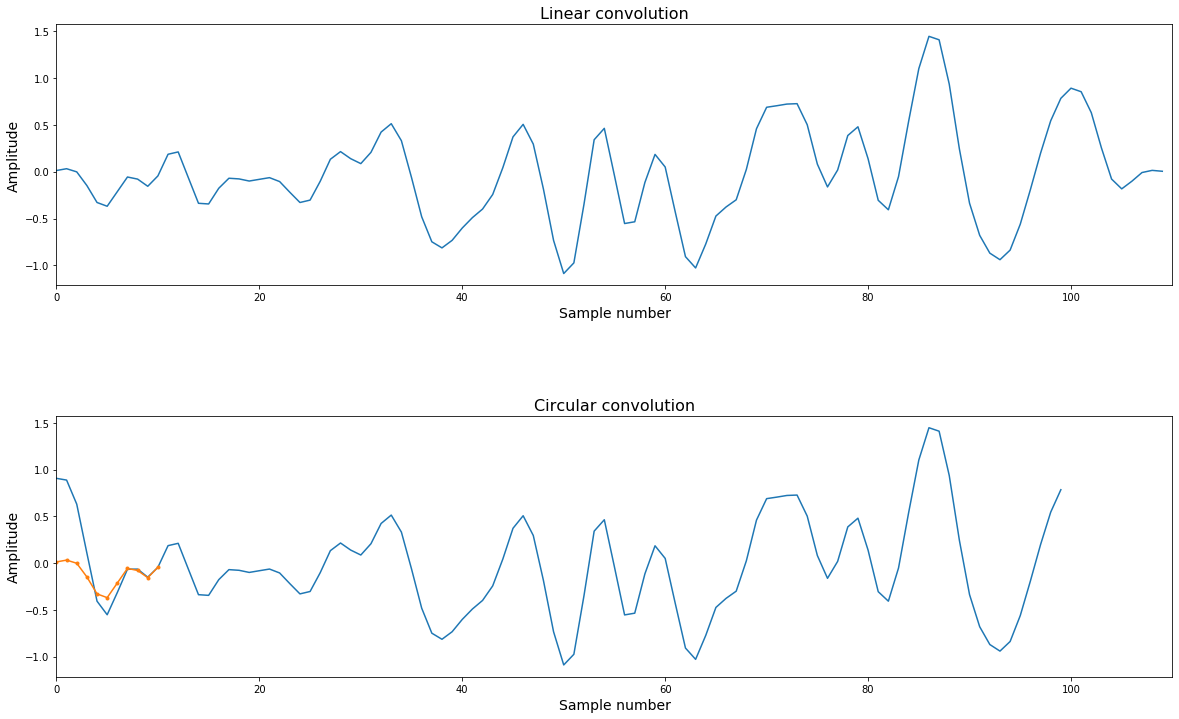

In [40]:
# Compute convolution using your implementation
direct = conv(f,g)

# Compute circular convolution
circular = circular_conv(f,g)

# Plots
plt.figure(figsize = (20,12))
plt.subplot(2,1,1)
plt.plot(direct)
plt.xlim(0,direct.shape[0])
plt.xlabel('Sample number', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)
plt.title('Linear convolution', fontsize = 16)

plt.subplot(2,1,2)
plt.plot(circular)
plt.xlim(0,direct.shape[0])
plt.xlabel('Sample number', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)
plt.title('Circular convolution', fontsize = 16)
plt.plot(direct[:g.shape[0]], '.-')
plt.subplots_adjust(hspace = 0.5)
plt.show()

### Question

- Why the result of circular convolution is different then the result of linear convolution?
- How many samples (in general) are affected?

########## Your answers goes here ##########
Wynikiem operacji splotu liniowego jest skończona ilość niezerowych wartości, zaś wynik operacji splotu kołowego powtarza
się cyklicznie (jest okresowy). Różnica między splotem liniowym i kołowym polega na zachodzeniu na siebie wartości z
różnych okresów. Aby to wyeliminować, stosuje się zero padding

## Linear convolution using Fourier Transform

### Exercise
Implement linear convolution using Fourier Transform. 

In [41]:
def linear_conv(f,g):
    """
    This function should calculate linear convolution of two signals in the frequency domain.
   
    Parameters
    ----------
    f: Numpy array of shape (N, ) containing first signal.
    g: Numpy array of shape (M, ) containing first signal.
    
    Returns
    -------
    X: numpy array of shape (N+M-1,) containing convoluted signals.

    """
    N = f.shape[0]
    M = g.shape[0]
    P = M + N - 1
    
    # zero padding sygnałów
    f = np.concatenate((f, np.zeros(P-N)), axis=0)
    g = np.concatenate((g, np.zeros(P-M)), axis=0)
    
    # liczymy DFT sygnałów a potem IDFT ich iloczynu
    F = np.fft.fft(f)
    G = np.fft.fft(g)
    X = F * G
    x = np.real(np.fft.ifft(X))
    return x

Verify you implementation.

RMSE: 0.0
Your implementation succeeded


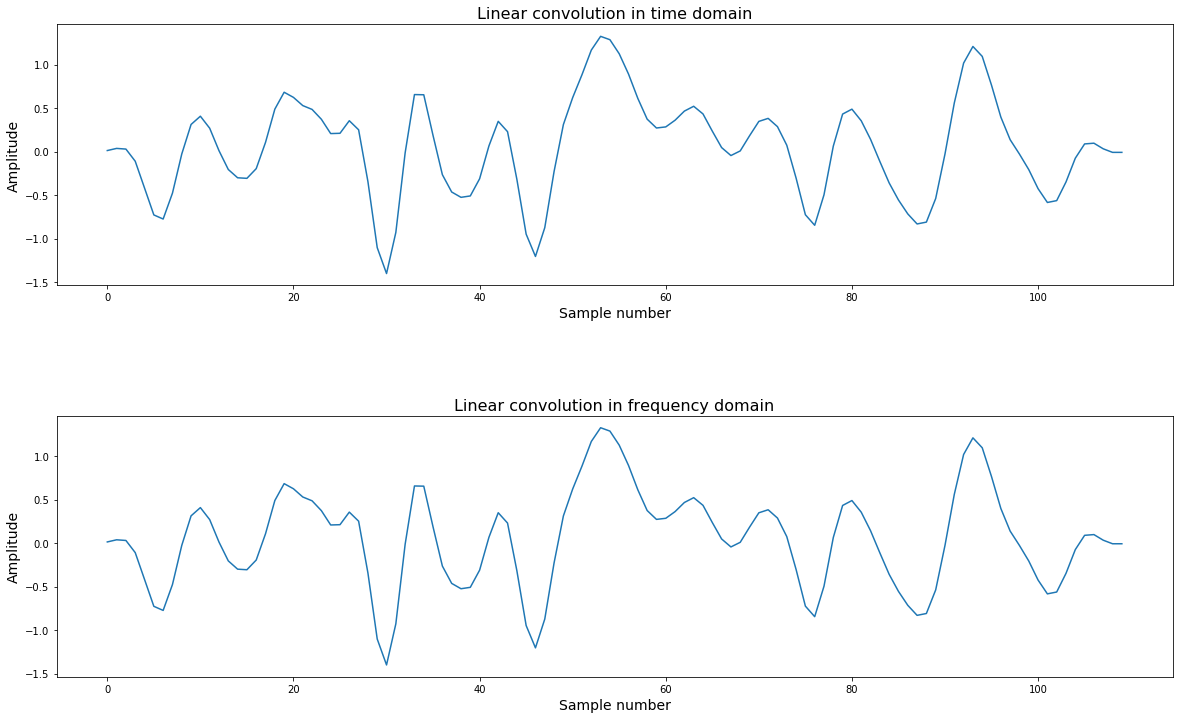

In [42]:
fs = 1e2  # Sampling frequency
dt = 1/fs # Sampling interval
t_s = 0   # Start of sampling 
t_s = 1   # End of sampling 

# Generate timestamps of samples
t = np.arange(0, 1, dt)

# Generate white noise signal
f = np.random.randn(*t.shape)

# Generate FIR coefs
g = np.array([-0.0101, -0.0260, -0.0027, 0.1071, 0.2626, 0.3385, 0.2626, 0.1071, -0.0027, -0.0260, -0.0101])

# Compute convolution using your implementation
X = linear_conv(f,g)

# Compute convolution using reference implementation from numpy
X_ref = np.convolve(f,g)

# Error between your implementation and reference implementation
X_err = np.abs(X - X_ref)**2

# RMSE
X_RMSE = np.sqrt(np.mean(X_err))

print('RMSE:', np.round(X_RMSE, 15))
print('Your implementation succeeded' if X_RMSE < 1e-10 else 'That RMSE is a little bit too BIG!')

# Ploting
direct = conv(f,g)
plt.figure(figsize = (20,12))
plt.subplot(2,1,1)
plt.plot(direct)
plt.xlabel('Sample number', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)
plt.title('Linear convolution in time domain', fontsize = 16)

linear = linear_conv(f,g)
plt.subplot(2,1,2)
plt.plot(linear)
plt.xlabel('Sample number', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)
plt.title('Linear convolution in frequency domain', fontsize = 16)

plt.subplots_adjust(hspace = 0.5)
plt.show()


## Overlap Add

Consider an input data x[n] of length N and a filter h[n] of lenth M. The linear convolution of the two sequences has length (N+M-1). To avoid time aliasing, the DFT length must be at least (N+M-1). However, in many aplication, such as filtering speech, the length of the input data is of indefinite duration. Computing the DFT of the entire input singal in this case can be inpractical and will cause a long delay, since we need all samples of the input before filtering. The solution is to use block convolution, in which the inut signal is segmented into sections of length L. Then, we can use the DFT to convolve each section with the filter, and get the desired linear convolution by fitting the filtered sections. The two most popular methods are [Overlap-add](https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method) and [Overlap-save](https://en.wikipedia.org/wiki/Overlap%E2%80%93save_method).


### Exercise 
Implement [Overlap-add Method](https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method)

- Segment the input signal into sections of L, and convolve each section with the filter of length M.
- Perform linear convolution for each sequence (DFT of length (L+M-1) allow us to compute the convolution without time aliasing).
- The nonzero points in the filtered sections will overlap by (M-1) points, and these overlap points should be added together to construct the output.

In [43]:
def overlap_add(f, g, L = 64):
    """
    This function should calculate linear convolution of two signals using Overlapp-add method.
   
    Parameters
    ----------
    f: Numpy array of shape (N, ) containing first signal.
    g: Numpy array of shape (M, ) containing first signal.
    L: Int containing length of the single sequence.
    
    Returns
    -------
    X: numpy array of shape (N+M-1,) containing convoluted signals.

    """
    
    ########## Your code  goes here ##########
    N = f.shape[0]                # długosc sygnalu
    M = g.shape[0]                # dlugosc wspolczynnikow filtra
    step_size = L - (M-1)         # okresla, ile próbek sygnału będzie liczone w danym obiegu pętli 
    
    segments = np.arange(0, N, step_size) # wektor numerów segmentów sygnału wejściowego
    
    X = np.zeros(N+L, dtype=np.complex128)
    g = np.concatenate((g, np.zeros(L-M)), axis=0)
    G = np.fft.fft(g)
    
    for n in segments:
        
        y = f[n:n+step_size]   # y oznacza u mnie fragment sygnału, który jest splatany w poszczególnym obiegu pętli
        y = np.concatenate((y, np.zeros(L-y.shape[0]))) # jego zero padding do długości L
        Y = np.fft.fft(y)                # po to żeby zrobić DFT
        X[n:n+L] += np.fft.ifft(Y * G)   # mnożenie z DFT współczynników filtru
                                         # dodajemy zachodzące na siebie punkty
    
    return X[:(N+M-1)]  # ograniczenie po to żeby uniknąć aliasingu
        
        

RMSE: 0.0
Your implementation succeeded


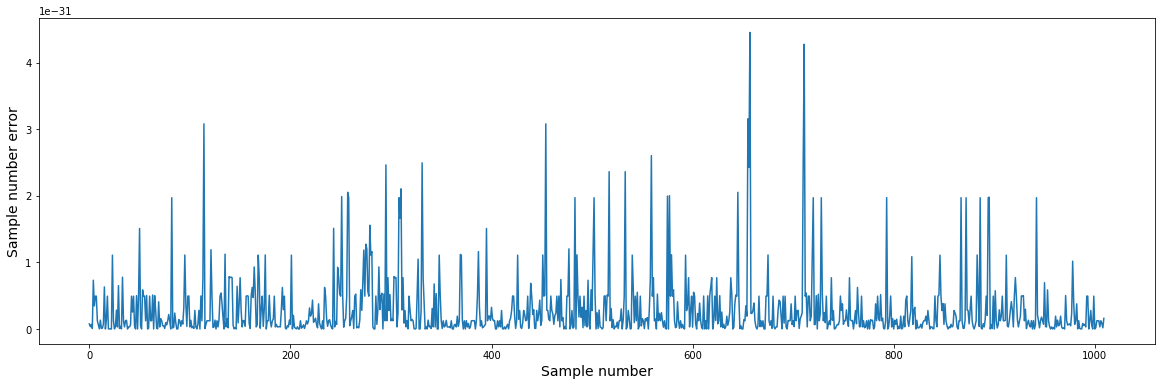

In [44]:
fs = 1e3 # Sampling frequency
dt = 1/fs # Sampling interval
t_s = 0   # Start of sampling 
t_s = 1   # End of sampling 

# Generate timestamps of samples
t = np.arange(0, 1, dt)

# Generate white noise signal
f = np.random.randn(*t.shape)

# Generate FIR coefs
g = np.array([-0.0101, -0.0260, -0.0027, 0.1071, 0.2626, 0.3385, 0.2626, 0.1071, -0.0027, -0.0260, -0.0101])

# Sequence length
L = 64

# Compute convolution using your implementation
X = overlap_add(f,g,L)

# Compute convolution using reference implementation from numpy
X_ref = np.convolve(f,g)

# Error between your implementation and reference implementation
X_err = np.abs(X - X_ref)**2

# RMSE
X_RMSE = np.sqrt(np.mean(X_err[:-L]))

print('RMSE:', np.round(X_RMSE, 15))
print('Your implementation succeeded' if X_RMSE < 1e-10 else 'That RMSE is a little bit too BIG!')

# Ploting
linear = linear_conv(f,g)
plt.figure(figsize = (20,6))
plt.plot(X_err)
plt.xlabel('Sample number', fontsize = 14)
plt.ylabel('Sample number error', fontsize = 14)

plt.show()

## Z transform

Analysis of continuous time LTI systems can be done using z-transforms. It is a powerful mathematical tool to convert differential equations into algebraic equations.

### Exercise

Calculate the [transmittance](https://en.wikipedia.org/wiki/Transfer_function#Linear_time-invariant_systems) of a system with given differential equation and then find the [zeros and the poles](https://en.wikipedia.org/wiki/Z-transform#Zeros_and_poles) of this system.


$$\large
    y(n) = x(n-1) + x(n-2) - 0.25y(n-1) + 0.375y(n-2)
$$


In [45]:
########## Here comes your answer ##########

# obliczenia na kartce
zeros = np.array([-1])
poles = np.array([-0.75, 0.5])

Plot your answer on the z-plane.

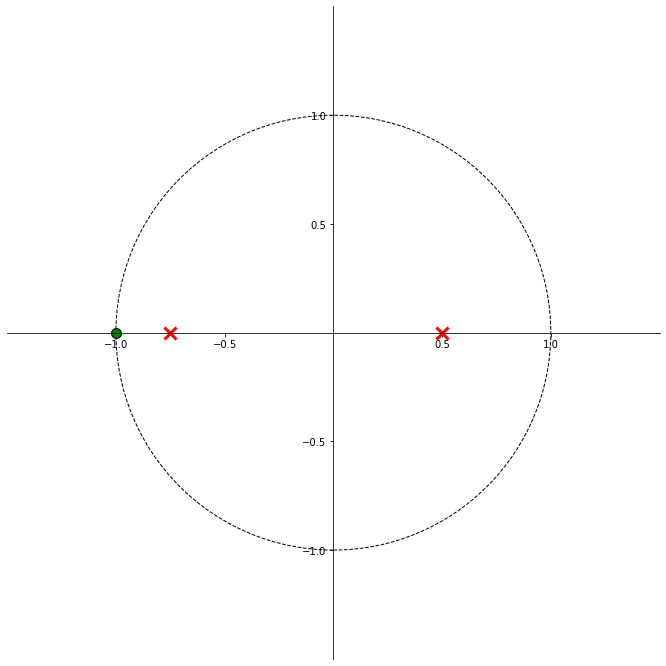

In [46]:
plt.figure(figsize= (20,12))

# get a figure/plot
ax = plt.subplot(111)

# create the unit circle
uc = patches.Circle((0,0), radius=1, fill=False,
                    color='black', ls='dashed')
ax.add_patch(uc)
    
# Plot the zeros and set marker properties    
t1 = plt.plot(zeros.real, zeros.imag, 'go', ms=10)
plt.setp( t1, markersize=10.0, markeredgewidth=1.0,
          markeredgecolor='k', markerfacecolor='g')

# Plot the poles and set marker properties
t2 = plt.plot(poles.real, poles.imag, 'rx', ms=10)
plt.setp( t2, markersize=12.0, markeredgewidth=3.0,
          markeredgecolor='r', markerfacecolor='r')

ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set the ticks
r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)
plt.show()